In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [ ]:
tflite_model_path = "ktp_classifier2.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
IMG_SIZE = (224, 224)
CLASS_NAMES = ["KTP", "Not KTP"]

def preprocess_image(image_path):
    """Load, resize, and normalize the image."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    image_resized = cv2.resize(image, IMG_SIZE)
    image_normalized = image_resized / 255.0
    return np.expand_dims(image_normalized, axis=0).astype(np.float32), image

def predict_image(image_path):
    """Predict the label of a single image."""
    input_data, original_image = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    prediction = output_data[0][0]
    predicted_label = CLASS_NAMES[0] if prediction < 0.5 else CLASS_NAMES[1]
    confidence = 1 - prediction if prediction < 0.5 else prediction
    return predicted_label, confidence, original_image

In [ ]:
image_folder = r"validation"
ground_truth = {"ktp352.jpg": "KTP", "non_ktp319.png": "Not KTP"} 


In [ ]:
predictions = []
true_labels = []
images_with_results = []

for file_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, file_name)
    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    try:
        predicted_label, confidence, original_image = predict_image(image_path)
        true_label = ground_truth.get(file_name, "Unknown")
        predictions.append(predicted_label)
        true_labels.append(true_label)
        
        annotated_image = original_image.copy()
        label_text = f"{predicted_label} ({confidence:.2f})"
        cv2.putText(annotated_image, label_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        images_with_results.append((annotated_image, file_name, label_text))

    except Exception as e:
        print(f"Error processing {file_name}: {e}")


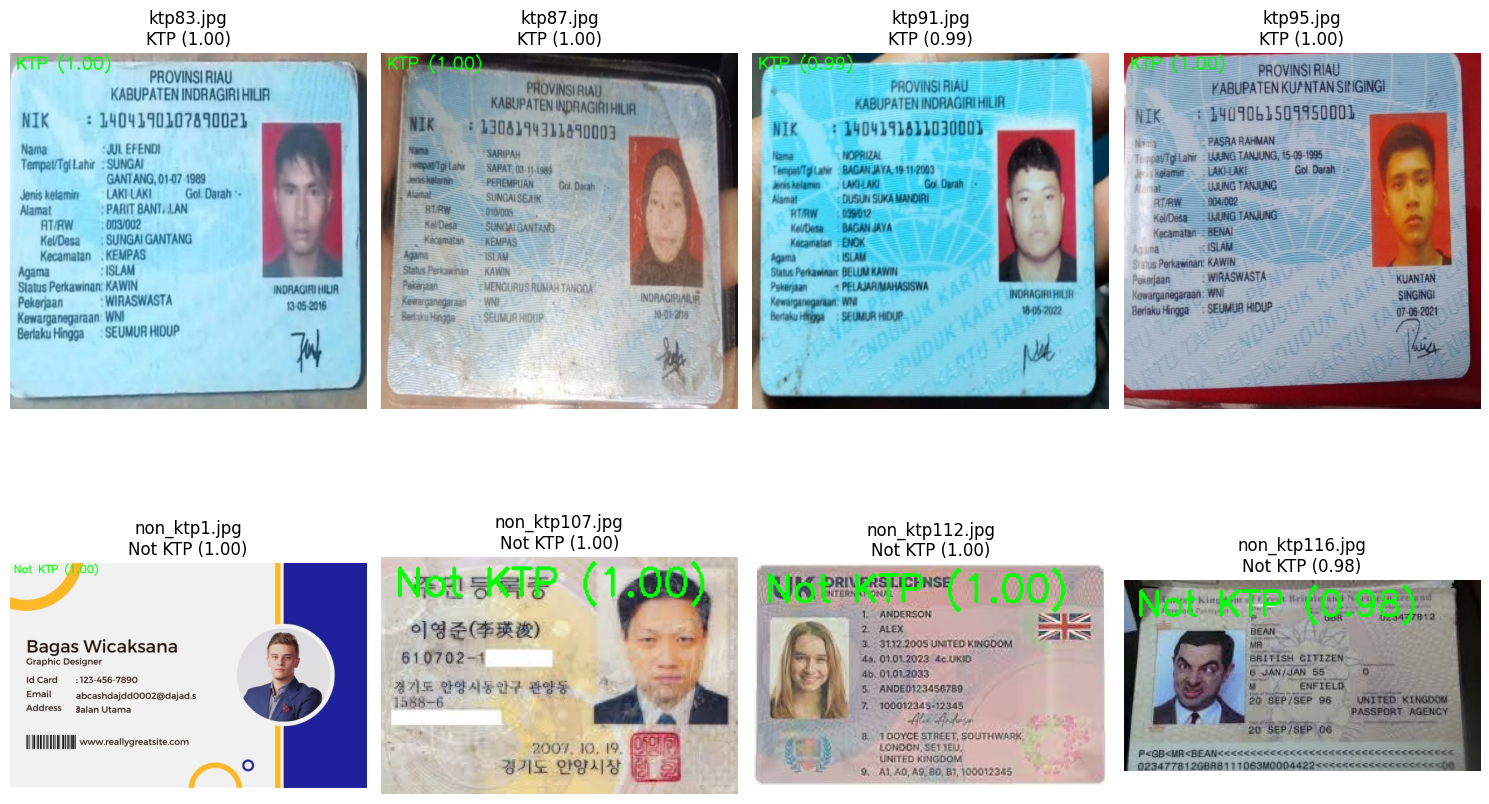

In [ ]:
plt.figure(figsize=(15, 10))
for idx, (image, file_name, label_text) in enumerate(images_with_results[26:34]):
    plt.subplot(2, 4, idx + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"{file_name}\n{label_text}")
    plt.axis("off")
plt.tight_layout()
plt.show()